# Generating digits
From mnist

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


# Hyperparameters

In [2]:
mnist_data = mnist.load_data()
_, img_rows, img_cols = mnist_data[0][0].shape
channels = 1

img_shape = (img_rows, img_cols, channels)

# Size of the noise vector
z_dim = 100

# Generator

In [3]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    
    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))
    
    # Activation
    model.add(LeakyReLU(alpha=0.01))
    
    # Output layer
    model.add(Dense(img_rows * img_cols * channels, activation='tanh'))
    
    # Reshape the generator output to image dimensions
    model.add(Reshape(img_shape))
    
    return model

# Discriminator

In [4]:
def build_discriminator(img_shape):
    
    model = Sequential()
    
    # input image
    model.add(Flatten(input_shape=img_shape))
    
    model.add(Dense(128))
    
    # Activation
    model.add(LeakyReLU(alpha=0.01))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Build the model

In [5]:
def build_gan(generator, discriminator):
    
    model = Sequential()
    
    # Combined Generator <-> Discriminator
    model.add(generator)
    model.add(discriminator)
    
    return model

In [6]:
# Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Generator
generator = build_generator(img_shape, z_dim)

# Keeps discriminator's parameters constant for generator training
discriminator.trainable = False

# Build and compile
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Training

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iteractions, batch_size, sample_interval):
    (X_train, _), (_,_) = mnist_data
    # Rescale mnist data from [0, 255] to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    
    # Labels for real images
    real = np.ones((batch_size, 1))
    
    # Labels for fake images
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iteractions):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train the generator
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            
            # Output a generated image sample
            sample_images(generator)

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_cols=4):
    # Random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_cols, z_dim))
    
    gen_imgs = generator.predict(z)
    
    # Rescale values to 0, 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_cols,
                           figsize=(4, 4),
                           sharey=True,
                           sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

# Train the GAN and inspect output

/Users/stelling/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/stelling/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.046084, acc.: 100.00%] [G loss: 3.443413]
2000 [D loss: 0.104831, acc.: 94.53%] [G loss: 4.971251]
3000 [D loss: 0.283812, acc.: 87.11%] [G loss: 4.598492]
4000 [D loss: 0.133065, acc.: 94.92%] [G loss: 4.507991]
5000 [D loss: 0.302164, acc.: 87.11%] [G loss: 2.950898]
6000 [D loss: 0.478562, acc.: 79.69%] [G loss: 2.779346]
7000 [D loss: 0.229440, acc.: 89.45%] [G loss: 4.183547]
8000 [D loss: 0.341207, acc.: 85.94%] [G loss: 3.523790]
9000 [D loss: 0.381264, acc.: 82.03%] [G loss: 3.035830]
10000 [D loss: 0.365063, acc.: 84.38%] [G loss: 2.988657]
11000 [D loss: 0.425940, acc.: 78.52%] [G loss: 3.403543]
12000 [D loss: 0.305206, acc.: 86.33%] [G loss: 3.499282]
13000 [D loss: 0.391465, acc.: 84.38%] [G loss: 3.307093]
14000 [D loss: 0.318540, acc.: 85.94%] [G loss: 3.399224]
15000 [D loss: 0.381008, acc.: 82.81%] [G loss: 2.683904]
16000 [D loss: 0.300991, acc.: 84.38%] [G loss: 2.708795]
17000 [D loss: 0.533861, acc.: 75.39%] [G loss: 2.288648]
18000 [D loss: 0.40443

/Users/stelling/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


22000 [D loss: 0.320614, acc.: 85.94%] [G loss: 2.787919]
23000 [D loss: 0.347913, acc.: 83.59%] [G loss: 2.542629]
24000 [D loss: 0.406196, acc.: 80.08%] [G loss: 2.396127]
25000 [D loss: 0.326651, acc.: 85.16%] [G loss: 2.160490]
26000 [D loss: 0.404517, acc.: 82.42%] [G loss: 2.176523]
27000 [D loss: 0.344442, acc.: 86.33%] [G loss: 2.664096]
28000 [D loss: 0.462563, acc.: 80.47%] [G loss: 2.095835]
29000 [D loss: 0.311571, acc.: 85.16%] [G loss: 2.194379]
30000 [D loss: 0.352696, acc.: 84.38%] [G loss: 2.343528]
31000 [D loss: 0.471999, acc.: 79.30%] [G loss: 2.298609]
32000 [D loss: 0.402667, acc.: 81.25%] [G loss: 2.506150]
33000 [D loss: 0.459219, acc.: 77.73%] [G loss: 2.303617]
34000 [D loss: 0.308995, acc.: 86.33%] [G loss: 2.118655]
35000 [D loss: 0.448917, acc.: 77.73%] [G loss: 1.834242]
36000 [D loss: 0.348819, acc.: 84.77%] [G loss: 2.181512]
37000 [D loss: 0.503422, acc.: 74.22%] [G loss: 1.627141]
38000 [D loss: 0.515454, acc.: 74.61%] [G loss: 1.933918]
39000 [D loss:

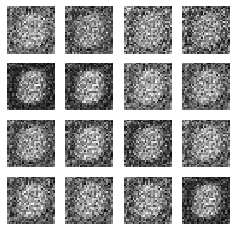

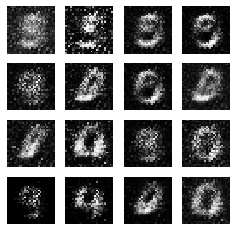

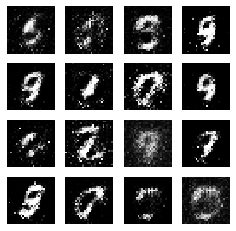

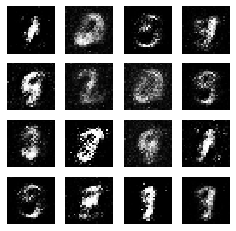

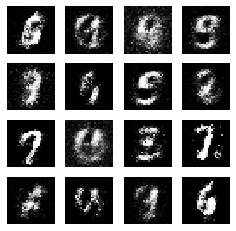

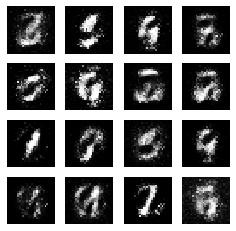

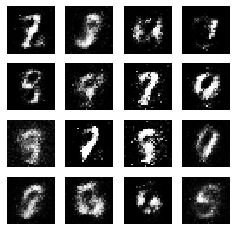

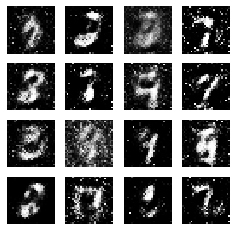

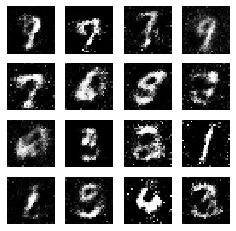

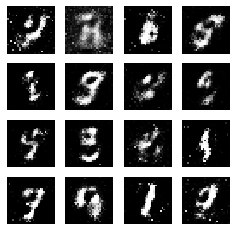

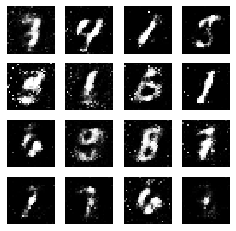

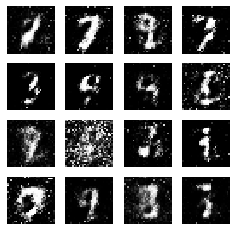

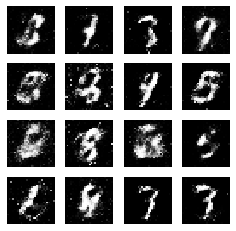

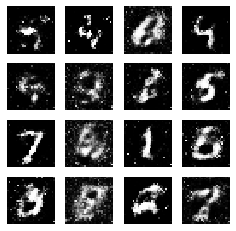

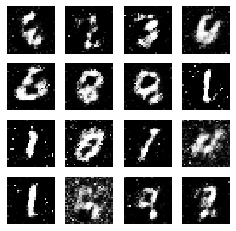

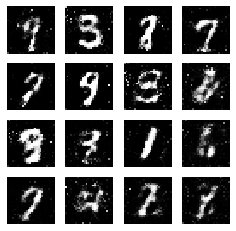

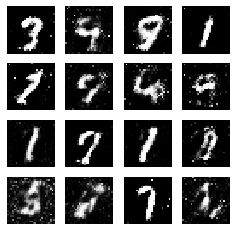

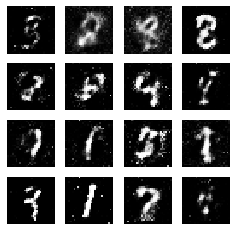

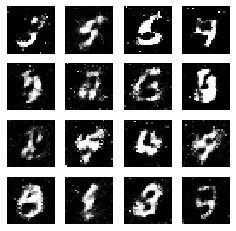

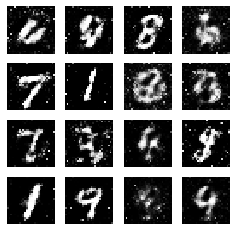

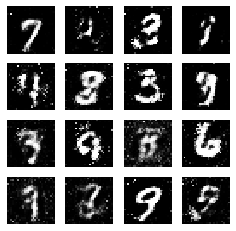

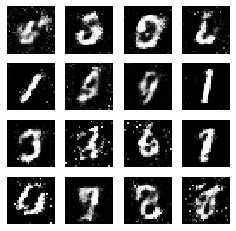

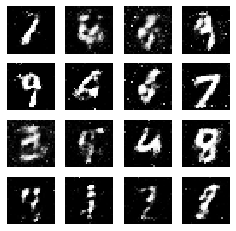

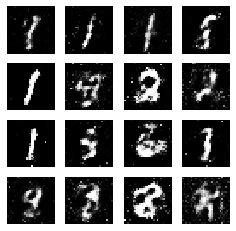

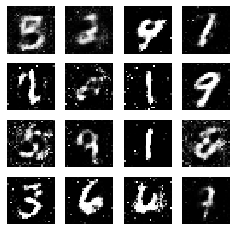

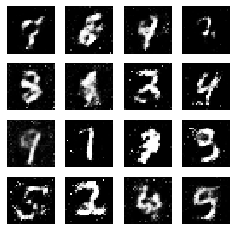

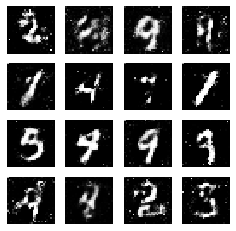

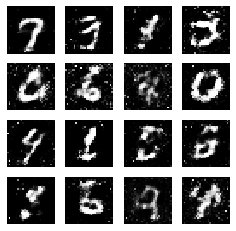

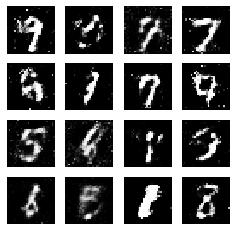

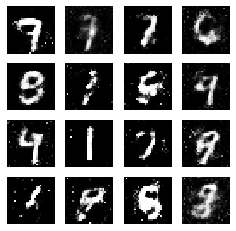

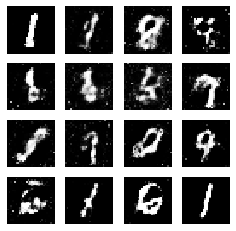

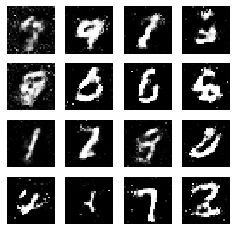

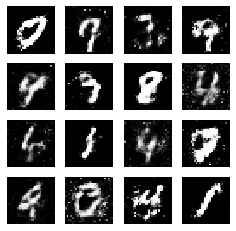

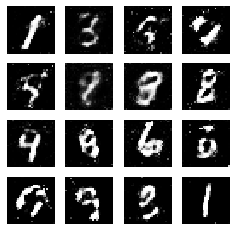

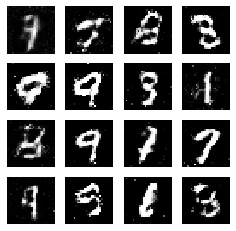

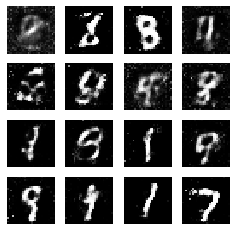

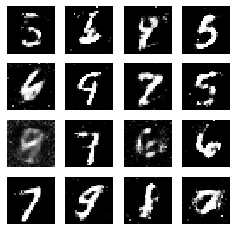

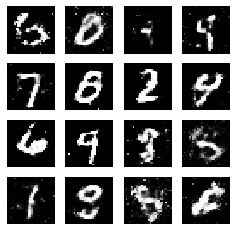

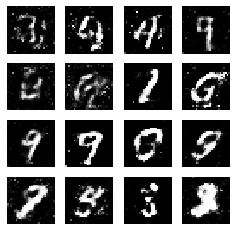

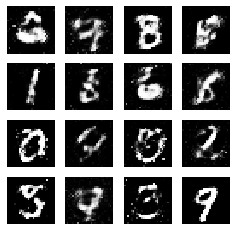

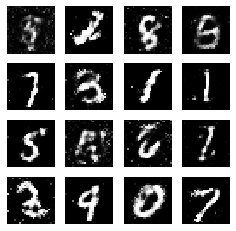

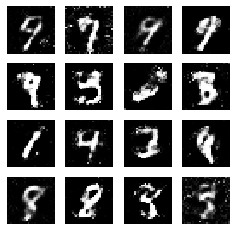

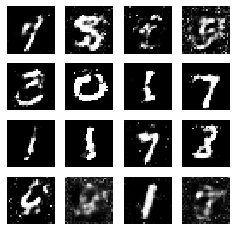

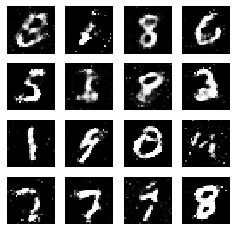

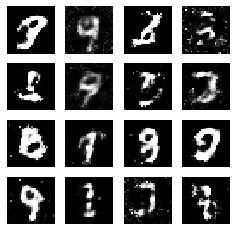

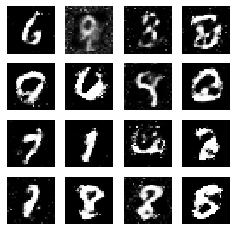

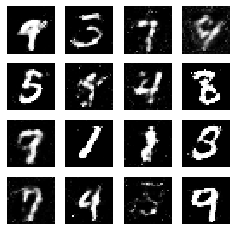

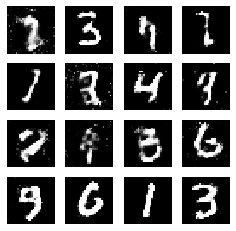

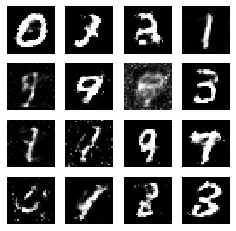

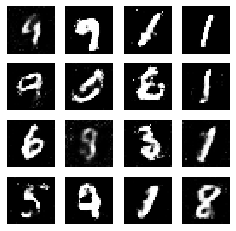

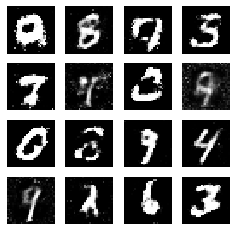

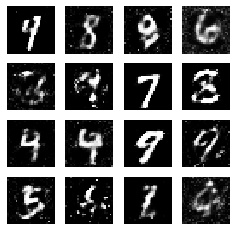

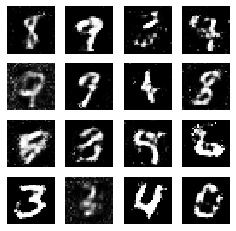

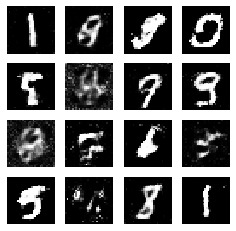

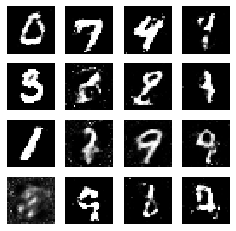

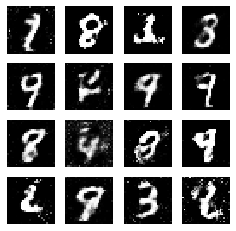

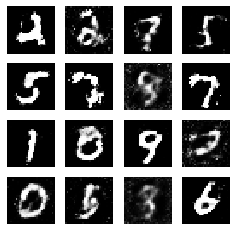

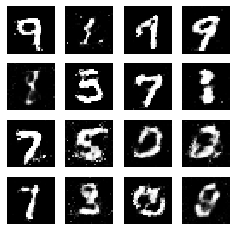

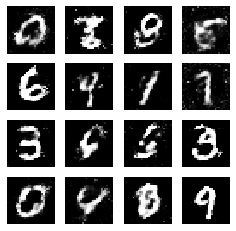

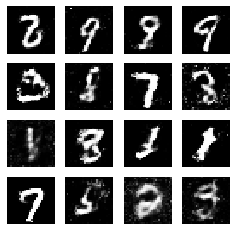

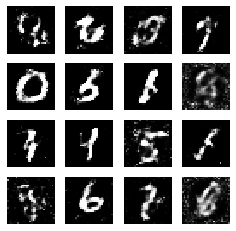

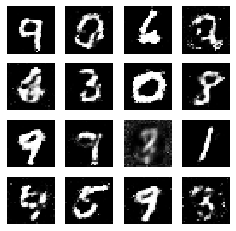

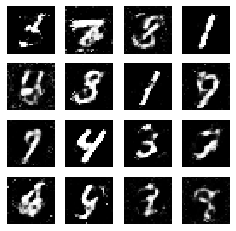

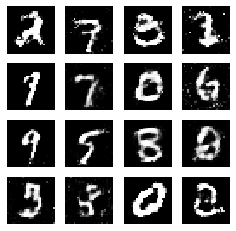

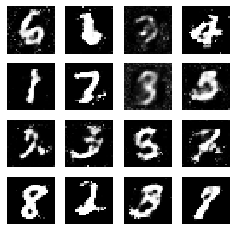

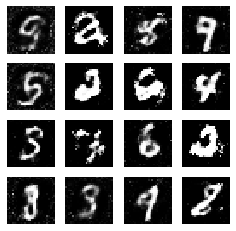

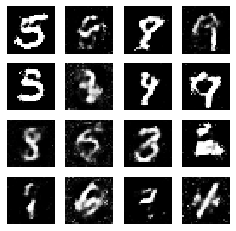

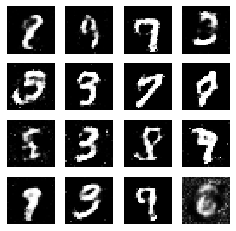

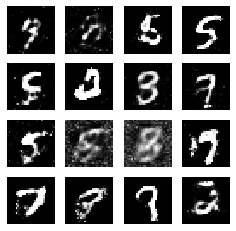

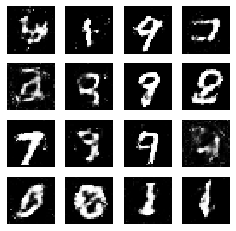

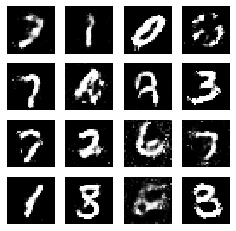

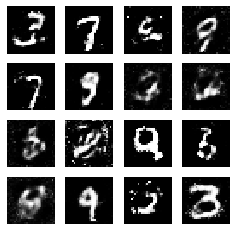

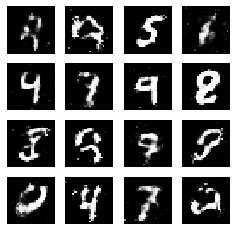

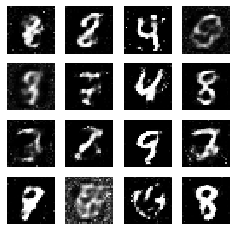

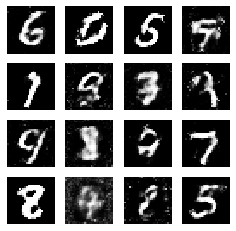

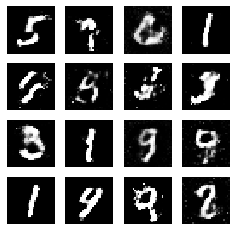

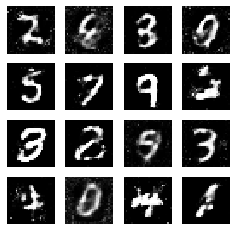

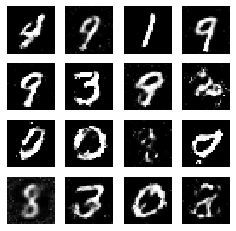

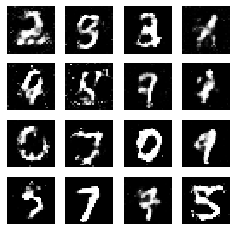

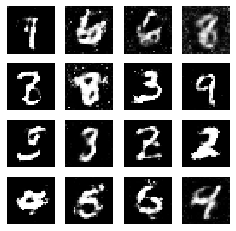

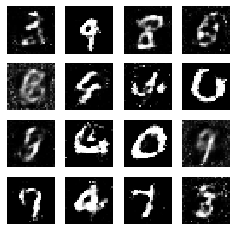

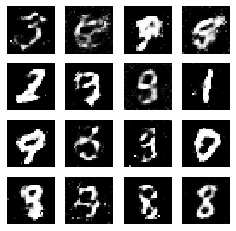

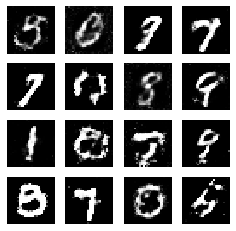

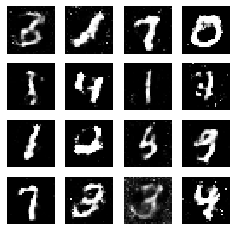

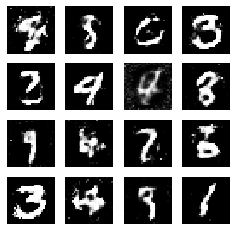

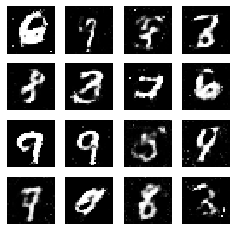

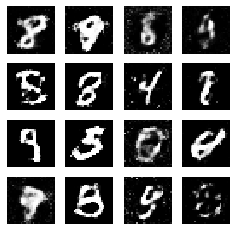

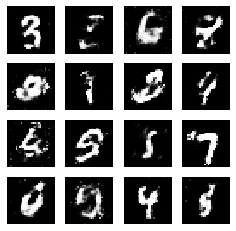

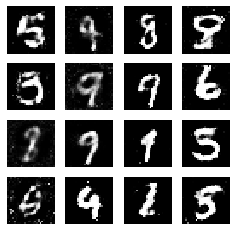

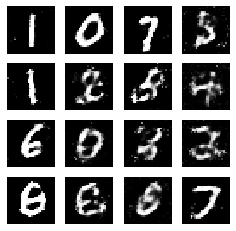

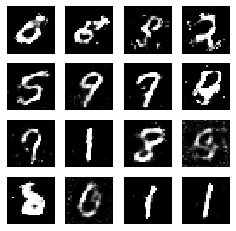

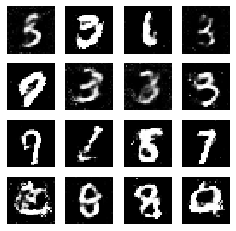

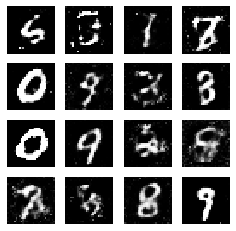

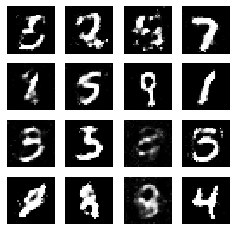

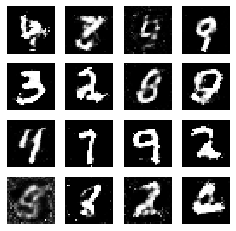

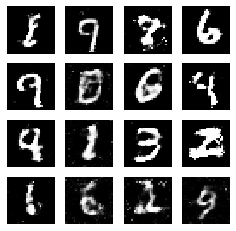

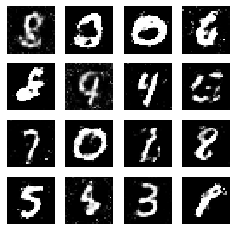

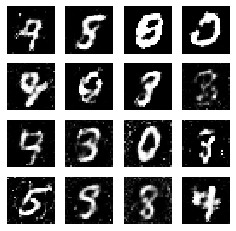

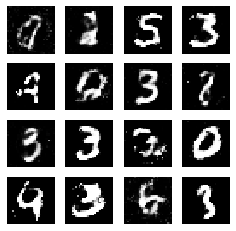

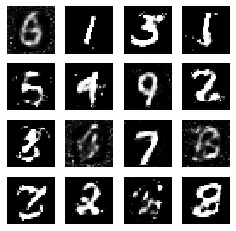

In [9]:
iteractions = 100000
batch_size = 128
sample_interval = 1000

# Train the GAN
train(iteractions, batch_size, sample_interval)

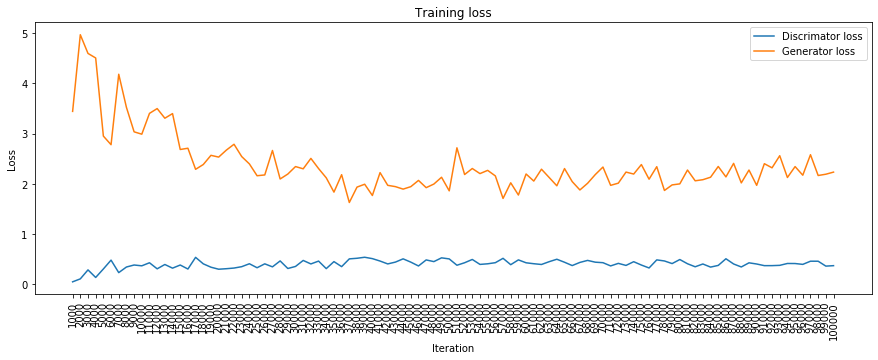

In [10]:
losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discrimator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

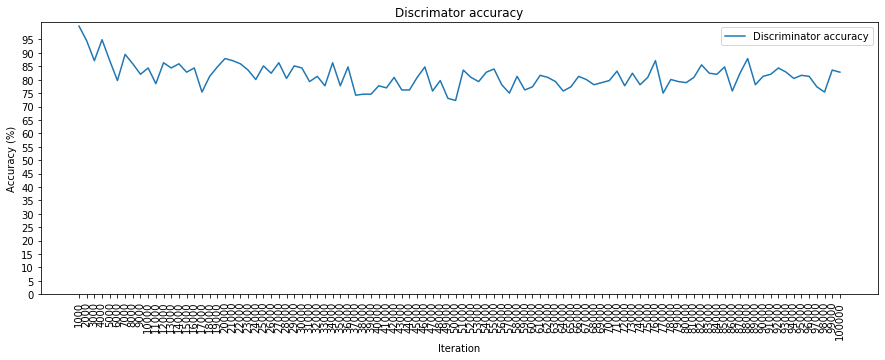

In [11]:
accuracies = np.array(accuracies)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label='Discriminator accuracy')
plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title('Discrimator accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()